In [2]:
import ipdb
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pylab as pylab
import cartopy
import cartopy.crs as ccrs
from utils import constants as cnst
from eod import msg
from utils import u_grid, u_interpolate as u_int, u_darrays as uda, u_arrays as ua
import datetime
import matplotlib.colors as mcolors
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from utils import u_plot as uplot
import salem
import numpy.ma as ma
from scipy import stats
import warnings
from scipy.ndimage.measurements import label
import shapely.geometry as shpg
import datetime

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [3]:
fpath = cnst.network_data + 'figs/HUARAZ/'

In [4]:
corr_all = xr.open_dataset('/home/ck/DIR/mymachine/GRIDSAT/MCS18_peru/correlations/GRIDSAT-30_u_correlation_3dRolling_SouthAmerica_1985-2018_diffs.nc')
corr_first = xr.open_dataset('/home/ck/DIR/mymachine/GRIDSAT/MCS18_peru/correlations/GRIDSAT-30_u_correlation_3dRolling_SouthAmerica_1985-2003_diffs.nc')
corr_end = xr.open_dataset('/home/ck/DIR/mymachine/GRIDSAT/MCS18_peru/correlations/GRIDSAT-30_u_correlation_3dRolling_SouthAmerica_2000-2018_diffs.nc')


# corr_first = xr.open_dataset('/home/ck/DIR/mymachine/GRIDSAT/MCS18_peru/correlations/GRIDSAT_u_correlation_SouthAmerica_1985-2004_diffs.nc')
# corr_end = xr.open_dataset('/home/ck/DIR/mymachine/GRIDSAT/MCS18_peru/correlations/GRIDSAT_u_correlation_SouthAmerica_1998-2018_diffs.nc')
# corr_all15 = xr.open_dataset('/home/ck/DIR/mymachine/GRIDSAT/MCS18_peru/correlations/GRIDSAT-15_u_correlation_SouthAmerica_1985-2018_diffs.nc')

In [5]:
def readERA(var):

    u200orig = xr.open_dataset('/media/ck/Elements/SouthAmerica/ERA5/hourly/'+var+'_15UTC_1981-2019_peru_big.nc')
    u200orig = uda.flip_lat(u200orig)
    datetimes = pd.to_datetime(u200orig.time.values)
    newtimes = []
    for t in datetimes:
        newtimes.append(t.replace(hour=0))
    u200orig['time'] = ('time', newtimes)
    return u200orig

In [6]:
era = readERA('u200')
era = era.sel(latitude=slice(-25,0), longitude=slice(-81,-65))

In [7]:
era850 = readERA('v850')
era850 = era850.sel(latitude=slice(-25,0), longitude=slice(-81,-65)).load()

In [8]:
m1=9
m2=4

In [9]:
era_alls = era['u'].sel(time=((era['time.year']>=1985)&(era['time.year']<=2002) & ((era['time.month']>=m1)|(era['time.month']<=m2))))
era_all = era_alls.where(era_alls<=-5).groupby('time.year').count('time').mean('year')

In [10]:
era_all_850 =  era850['v'].sel(time=((era850['time.year']>=1985)&(era850['time.year']<=2002) & ((era850['time.month']>=m1)|(era850['time.month']<=m2))))
era_ends = era['u'].sel(time=((era['time.year']>=2002)&(era['time.year']<=2018) & ((era['time.month']>=m1)|(era['time.month']<=m2))))

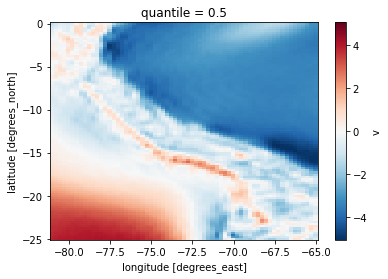

In [11]:
#plt.figure(figsize=(15,7), dpi=200)
era_all_850.quantile([0.5], dim='time').plot()

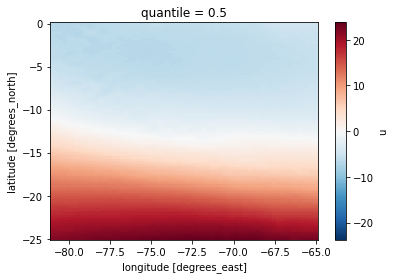

In [12]:
(era_ends.quantile([0.5], dim='time')).plot()

In [13]:
era_all_850 = era_all_850.where(era_all_850<=-5).groupby('time.year').count('time').mean('year')
era_end = era_ends.where(era_ends<=-5).groupby('time.year').count('time').mean('year')

In [14]:
era_end_850 = era850['v'].sel(time=((era850['time.year']>=2002)&(era850['time.year']<=2018) & ((era850['time.month']>=m1)|(era850['time.month']<=m2))))
era_end_850 = era_end_850.where(era_end_850<=-5).groupby('time.year').count('time').mean('year')

In [15]:
g_on_era = xr.open_dataset('/home/ck/DIR/mymachine/GRIDSAT/MCS18_peru/aggs/daily_-40ALLkm2_DAY_onBIGERA_allyears.nc')


g_all = g_on_era['tir'].sel(time=((g_on_era['time.year']>=1985)&(g_on_era['time.year']<=2002) & ((g_on_era['time.month']>=m1)|(g_on_era['time.month']<=m2))))
g_all = g_all.where(g_all<=-4000).groupby('time.year').count('time').mean('year').load()

g_end = g_on_era['tir'].sel(time=((g_on_era['time.year']>=2002)&(g_on_era['time.year']<=2018) & ((g_on_era['time.month']>=m1)|(g_on_era['time.month']<=m2))))
g_end = g_end.where(g_end<=-4000).groupby('time.year').count('time').mean('year').load()

In [16]:
ch_on_era = xr.open_mfdataset('/media/ck/Elements/SouthAmerica/CHIRPS/SA_daily_onERA/CHIRPS_daily_onERA_*.nc')

ch_all = ch_on_era['precip'].sel(time=((ch_on_era['time.year']>=1985)&(ch_on_era['time.year']<=2002) & ((ch_on_era['time.month']>=m1)|(ch_on_era['time.month']<=m2))))

posgrid = np.intersect1d(ch_all.time, era_alls.time)
ch_all = ch_all.sel(time=posgrid)
ch_all_rain = ch_all.where((ch_all>=1) & (era_alls>=2)).groupby('time.year').count('time').mean('year').load()
ch_all_east =  ch_all.where((ch_all>=1) &(era_alls<=-2)).groupby('time.year').count('time').mean('year').load()
ch_all = ch_all.where((ch_all>=1)).groupby('time.year').count('time').mean('year').load()

ch_end = ch_on_era['precip'].sel(time=((ch_on_era['time.year']>=2002)&(ch_on_era['time.year']<=2018) & ((ch_on_era['time.month']>=m1)|(ch_on_era['time.month']<=m2))))
posgrid = np.intersect1d(ch_end.time, era_ends.time)
ch_end = ch_end.sel(time=posgrid)
ch_end_rain = ch_end.where((ch_end>=1) & (era_ends>=2)).groupby('time.year').count('time').mean('year').load()
ch_end_east = ch_end.where((ch_end>=1) & (era_ends<=-2)).groupby('time.year').count('time').mean('year').load()
ch_end = ch_end.where((ch_end>=1)).groupby('time.year').count('time').mean('year').load()

ch_all_frac = ch_all_east/ch_all*100
ch_end_frac = ch_end_east/ch_end*100

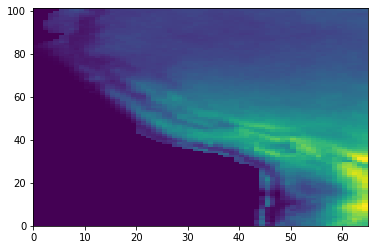

In [17]:
plt.pcolormesh(ch_end_rain)

In [18]:
corr_all = corr_all.assign_coords(dayofyear=corr_all.dayofyear.values)
corr_first = corr_first.assign_coords(dayofyear=corr_first.dayofyear.values)
corr_end = corr_end.assign_coords(dayofyear=corr_end.dayofyear.values)

In [19]:
corr_all = corr_all.sel(latitude=slice(-25,0), longitude=slice(-81,-65))
corr_first = corr_first.sel(latitude=slice(-25,0), longitude=slice(-81,-65))
corr_end = corr_end.sel(latitude=slice(-25,0), longitude=slice(-81,-65))

In [20]:
topo = xr.open_dataarray(cnst.TOPO_1MIN).sel(lon=slice(-81,-65), lat=slice(-25,0))
topo_on_g = corr_all.salem.lookup_transform(topo)

In [21]:
corr_first_num = corr_first['r'].where(corr_first['pval']<=0.05).count('dayofyear')

In [22]:
corr_end_num = corr_end['r'].where(corr_end['pval']<=0.05).count('dayofyear')


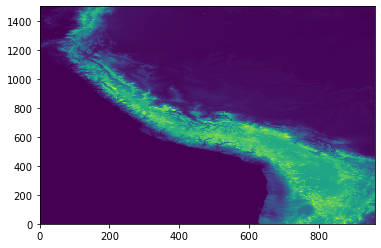

In [23]:
plt.pcolormesh(topo)

In [24]:
def find_doy(corr_all, gt_doy=None, lt_doy=None):
    
    if gt_doy is not None:
        mask = corr_all.dayofyear>gt_doy
        pindex = 0
        rcheck = -60  #-60
    if lt_doy is not None:
        mask = corr_all.dayofyear<lt_doy
        pindex = -1
        rcheck = 60 #60
        
    corr = corr_all.sel(dayofyear=mask)
    corr_sig = corr.where(corr['pval']<=0.05)
   
    array = corr_sig['r'].values

    thresh = 0.1
    array[array <= thresh] = 0  # T threshold maskout
    array[np.isnan(array)] = 0  # set ocean nans to 0
    outarr_3 = np.zeros((array.shape[1], array.shape[2]))
    outarr_5 = np.zeros((array.shape[1], array.shape[2]))
    outarr_max = np.zeros((array.shape[1], array.shape[2]))

    for x in range(array.shape[2]):
        for y in range(array.shape[1]):
            
            ts = array[:,y,x]
            labels, numL = label(ts)

            u, inv = np.unique(labels, return_inverse=True)
            n = np.bincount(inv)

            inds_3 = u[(n>=3)&(u!=0)] ## min 3 days onset
            inds_5 = u[(n>=5)&(u!=0)] ## min 5 days breakdown
            

            if len(inds_3)>0:
                pos3 = np.where(labels==inds_3[pindex])
                day3 = ((corr_sig.dayofyear.values+1)[(pos3[0])[pindex]])
            else:
                day3 = np.nan

            if len(inds_5)>0:
                pos5 = np.where(labels==inds_5[pindex])
                day5 = ((corr_sig.dayofyear.values+1)[pos5[0][pindex]])
            else:
                day5 = np.nan

            if (pindex==0) & (np.sum(array[rcheck::,y,x]==0)/abs(rcheck)>0.85):  # remove pixels where more than 40 days in Nov/Dev have no correlation
                day3 = np.nan
                day5 = np.nan
            if (pindex==-1) & (np.sum(array[::rcheck,y,x]==0)/abs(rcheck)>0.85): # remove pixels where more than 40 days in Jan/Feb have no correlation
                day3 = np.nan
                day5 = np.nan

            outarr_3[y,x] = day3
            outarr_5[y,x] = day5
            outarr_max[y,x] = (corr_sig.dayofyear.values+1)[np.argmax(ts)]
            
    outarr_3 = xr.DataArray(outarr_3, coords=[corr['latitude'], corr['longitude']], dims=['latitude','longitude'])
    outarr_5 = xr.DataArray(outarr_5, coords=[corr['latitude'], corr['longitude']], dims=[ 'latitude','longitude'])
            
#     grid = corr.salem.grid.regrid(factor=1)
#     #ipdb.set_trace()
#     outarr_3 = grid.lookup_transform(outarr_3)
#     outarr_5 = grid.lookup_transform(outarr_5)
#     grid = grid.to_dataset()
#     outarr_3 = xr.DataArray(outarr_3, coords=[grid['y'], grid['x']], dims=['latitude','longitude'])
#     outarr_5 = xr.DataArray(outarr_5, coords=[grid['y'], grid['x']], dims=['latitude','longitude'])

    return outarr_3, outarr_5

In [25]:
def find_doy_max(corr_all, start, end, gt_doy=None, lt_doy=None):

    if gt_doy is not None:
        mask = corr_all.dayofyear>gt_doy
        pindex = 0
        rcheck = -75#-60
    if lt_doy is not None:
        mask = corr_all.dayofyear<lt_doy
        pindex = -1
        rcheck = 75#60
        
    corr = corr_all#.sel(dayofyear=mask)
    corr_sig = corr.where(corr['pval']<=0.05)
   
    array = corr_sig['r']

    thresh = 0.1
    array.values[array.values <= thresh] = 0  # T threshold maskout
    array.values[np.isnan(array.values)] = 0  # set ocean nans to 0
    
    outarr_max = np.zeros((array.shape[1], array.shape[2]))*np.nan
    corr_max = np.zeros((array.shape[1], array.shape[2]))*np.nan
    

    for x in range(array.shape[2]):
        for y in range(array.shape[1]):
            #ipdb.set_trace()
            ts = array.isel(longitude=x, latitude=y)
            starts = start.values[y,x]
            ends = end.values[y,x]
            
            if np.isnan(starts) | np.isnan(ends):
                continue
            
            #ipdb.set_trace()
            valmax = ts.isel(dayofyear=((ts.dayofyear>starts) | (ts.dayofyear<ends))).argmax()
            #ipdb.set_trace()
            doys = (ts.isel(dayofyear=((ts.dayofyear>starts) | (ts.dayofyear<ends))).dayofyear.values+1)[valmax]
            month = datetime.datetime(2017, 1, 1) + pd.Timedelta(str(doys - 1)+' days')
            outarr_max[y,x] = month.month
            corr_max[y,x] = ts.isel(dayofyear=((ts.dayofyear>starts) | (ts.dayofyear<ends)))[valmax]
            
    out_max = xr.DataArray(outarr_max, coords=[corr['latitude'], corr['longitude']], dims=['latitude','longitude'])
    corr_out_max = xr.DataArray(corr_max, coords=[corr['latitude'], corr['longitude']], dims=['latitude','longitude'])

    return out_max, corr_out_max

In [26]:
outarr_3, outarr_5 = find_doy(corr_all, gt_doy=213)  # doy 182 is 1st July
endarr_3, endarr_5= find_doy(corr_all, lt_doy=182)

In [27]:
outarr_3_first, outarr_5_first = find_doy(corr_first, gt_doy=213)  # doy 182 is 1st July
endarr_3_first, endarr_5_first= find_doy(corr_first, lt_doy=182)

In [28]:
outarr_3_end, outarr_5_end = find_doy(corr_end, gt_doy=213)  # doy 182 is 1st July
endarr_3_end, endarr_5_end= find_doy(corr_end, lt_doy=182)

In [29]:

corr_sig = corr_all.where(corr_all['pval']<=0.05)

array = corr_sig['r']

thresh = 0.1
array = array.where(array>=thresh, other=0)  # T threshold maskout

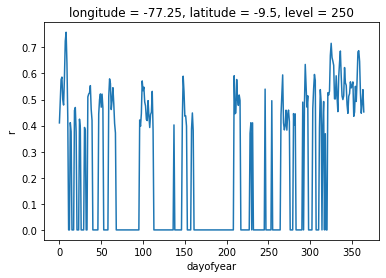

In [30]:
array.sel(longitude=-77.25, latitude=-9.5).plot()

In [31]:
np.sum(array.sel(longitude=-77.25, latitude=-9.5).values[-75::]<0.1)/ 75   #x = 15 , y=62

0.2

In [32]:
outmax_gt, corrmax = find_doy_max(corr_all, outarr_3, endarr_5, gt_doy=213)

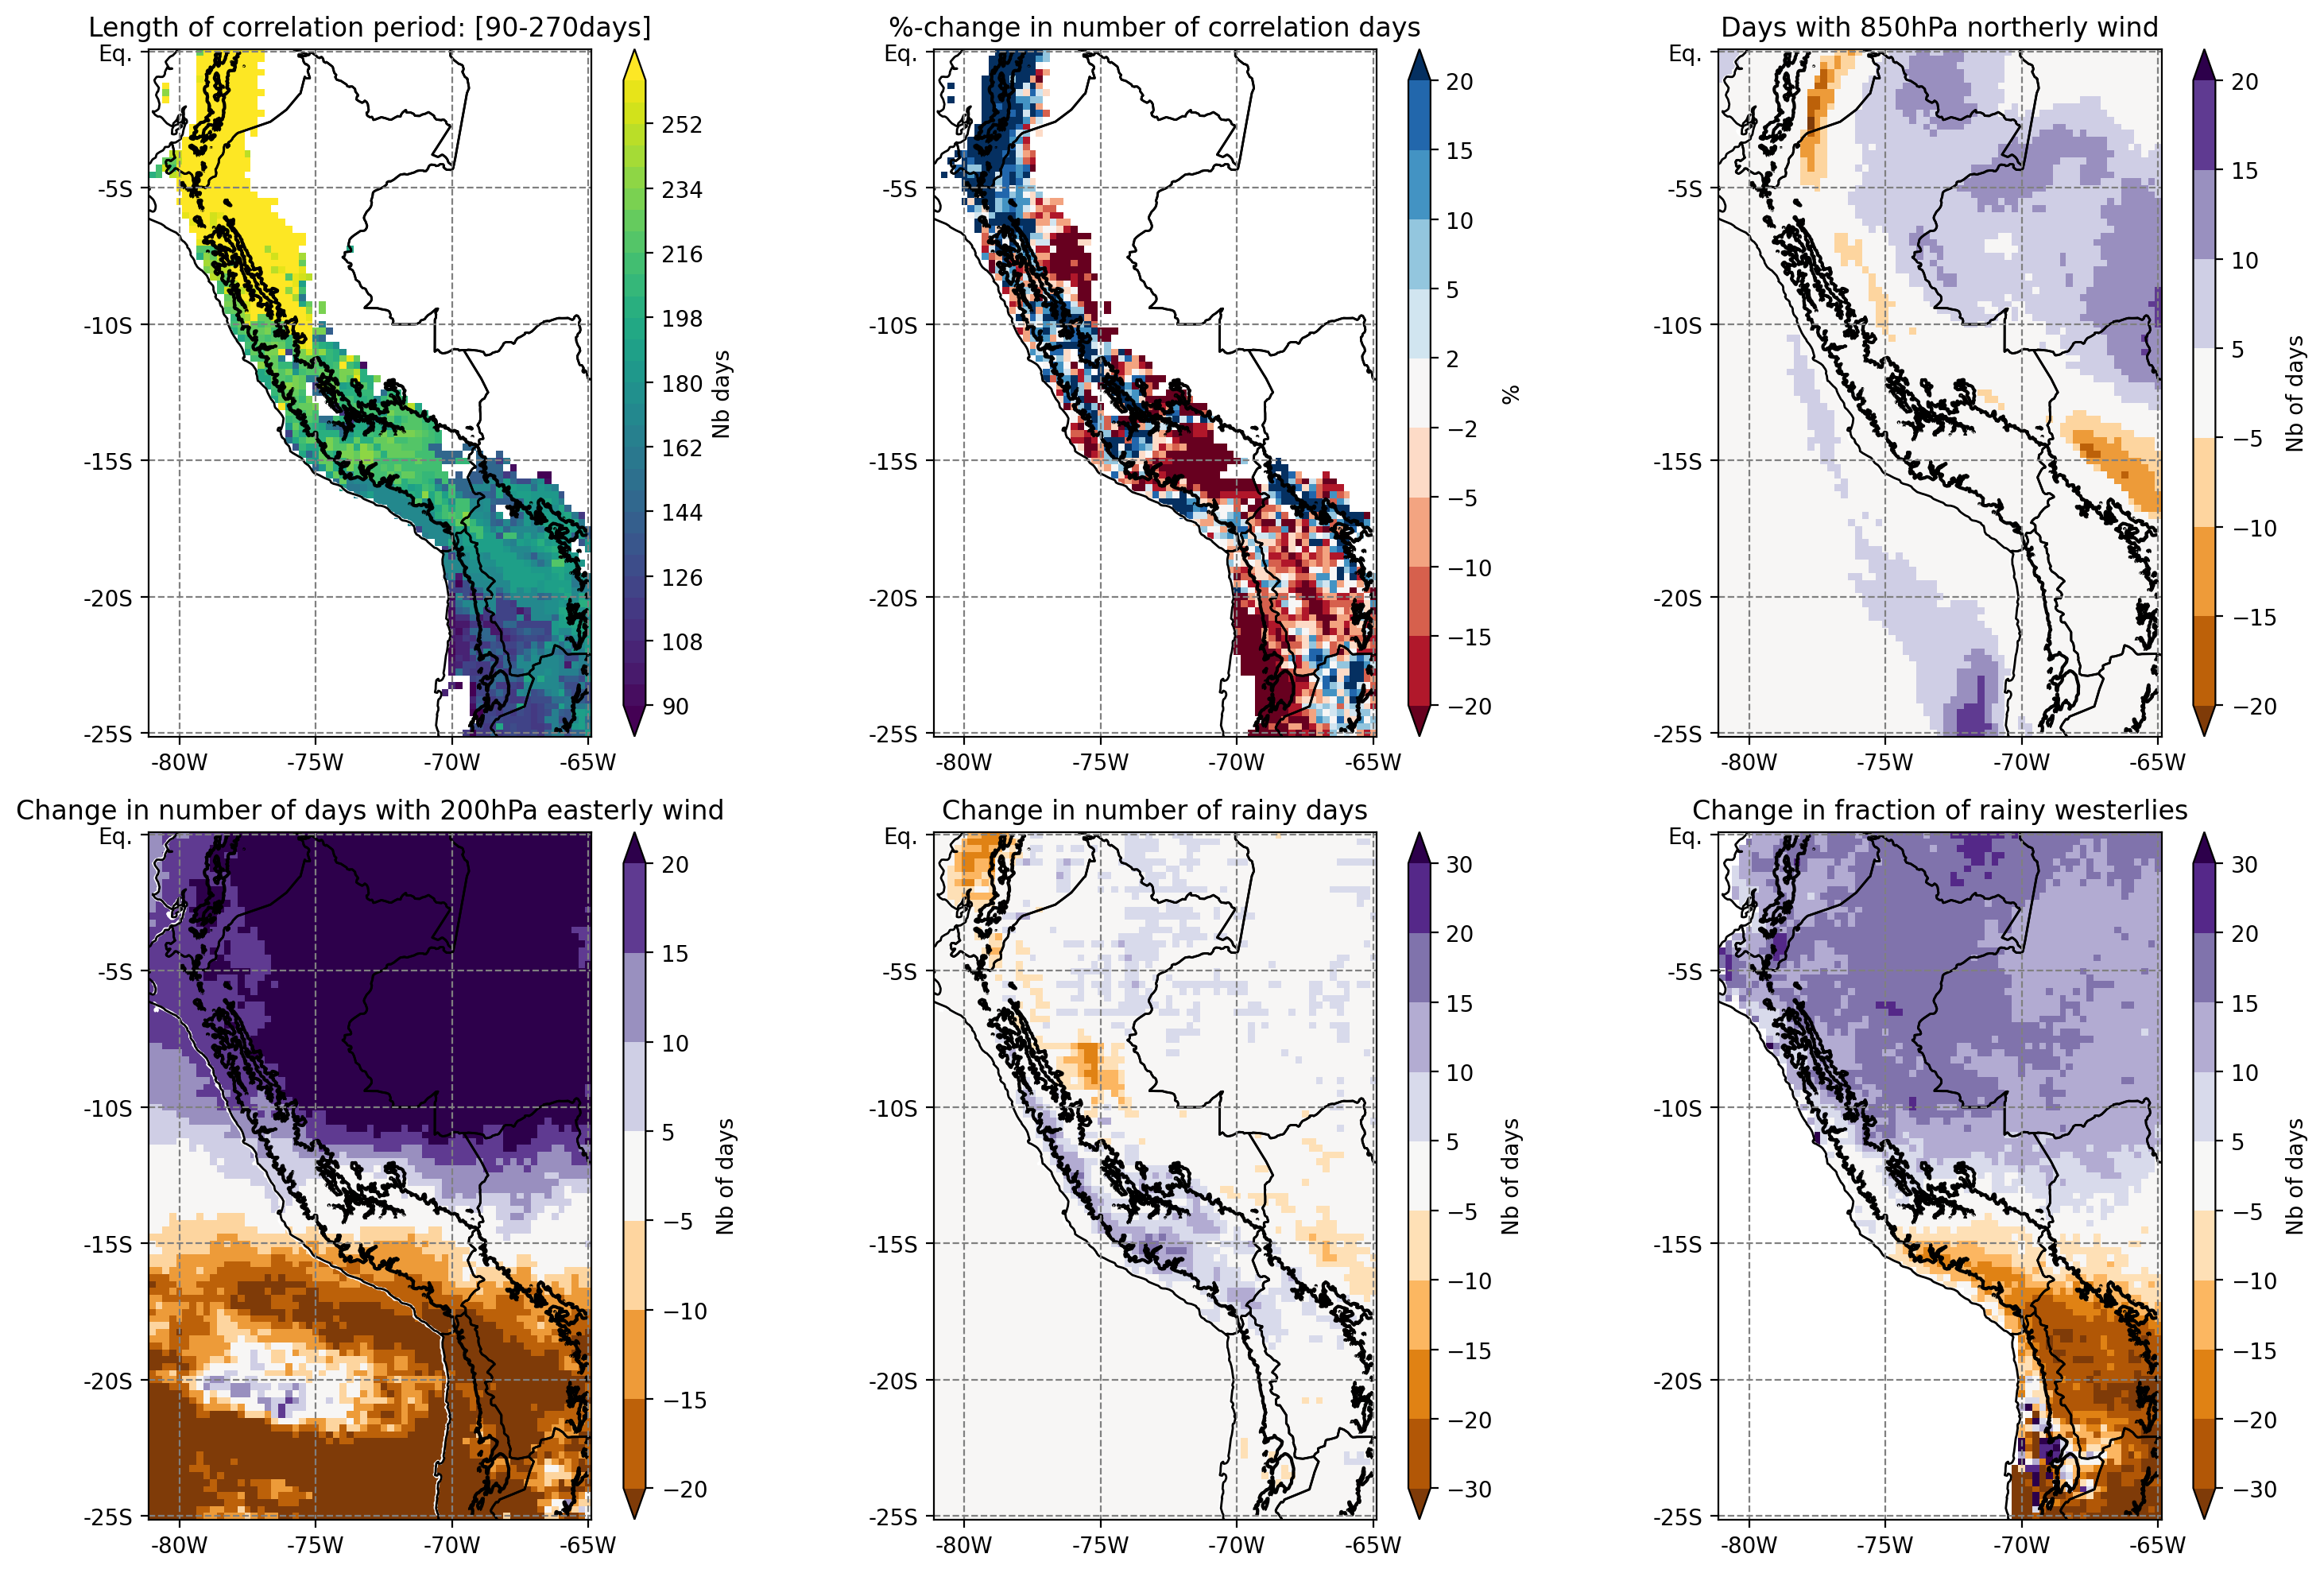

In [33]:
lakes = salem.read_shapefile(salem.get_demo_file('ne_50m_lakes.shp'),
                              cached=True)

map = corr_all.salem.get_map()
f = plt.figure(figsize=(15,10), dpi=200)

# ax = f.add_subplot(231)
# #outarr_3.values[(topo_on_g<300)]=np.nan
# map.set_data(outarr_3)
# map.set_plot_params(levels=np.arange(182,335,6), cmap='jet', extend='both') #[182,213,244,274,305,335, 366]  # 182-July, 335- December
# map.set_contour(topo, interp='linear', levels=[0,3000], cmap='Greys')
# plt.plot(-77.5, -9.5, 'ro', markersize=5)
# map.visualize(cbar_title='Day of year', title='3-day correlation onset [July-November]')

# ax = f.add_subplot(232)
# endarr_5.values[(topo_on_g<300)]=np.nan # | (endarr_5<65)
# map.set_data(endarr_5)
# map.set_plot_params(levels=np.arange(60,152,6), cmap='jet_r', extend='both') # 60 March, 152 June
# map.set_contour(topo, interp='linear', levels=[0,3000], cmap='Greys')
# map.visualize(cbar_title='Day of year', title='5-day correlation retreat [March-May]')
# plt.plot(-77.5, -9.5, 'ro', markersize=5)

ax = f.add_subplot(231)
endarr_5.values[(topo_on_g<300)]=np.nan # | (endarr_5<65)
season = (365-outarr_3)+endarr_5
map.set_data(season)
map.set_plot_params(levels=np.arange(90,270,6), cmap='viridis', extend='both') #np.arange(90,270,6)
map.set_contour(topo, interp='linear', levels=[0, 3000], cmap='Greys')
map.visualize(cbar_title='Nb days', title='Length of correlation period: [90-270days]')
plt.plot(-77.5, -9.5, 'ro', markersize=5)


ax = f.add_subplot(232)
data = ((corr_end_num-corr_first_num)/corr_first_num)*100
data.values[(corr_first_num.values<30)]=np.nan
data.values[np.isnan(season)] = np.nan
#data[(topo_on_g<300)]=np.nan # | (endarr_5<65)
map.set_data(data)
map.set_plot_params(levels=[-20,-15,-10, -5, -2,2, 5,10,15,20], cmap='RdBu', extend='both')
map.set_contour(topo, interp='linear', levels=[0, 3000], cmap='Greys')
map.visualize(cbar_title='%', title='%-change in number of correlation days')
plt.plot(-77.5, -9.5, 'ro', markersize=5)

ax = f.add_subplot(233)
data = ((era_end_850-era_all_850))
#data.values[corr_all_num.values<60]=np.nan
#endarr_5[(topo_on_g<300)]=np.nan # | (endarr_5<65)
map.set_data(data)
map.set_plot_params(levels=[-20,-15,-10, -5, 5,10,15,20], cmap='PuOr', extend='both')
map.set_contour(topo, interp='linear', levels=[0,3000], cmap='Greys')
map.visualize(cbar_title='Nb of days', title='Days with 850hPa northerly wind')
plt.plot(-77.5, -9.5, 'ro', markersize=5)

ax = f.add_subplot(234)
data = ((era_end-era_all))/era_all*100
#data.values[corr_all_num.values<60]=np.nan
#endarr_5[(topo_on_g<300)]=np.nan # | (endarr_5<65)
map.set_data(data)
map.set_plot_params(levels=[-20,-15,-10, -5, 5,10,15,20], cmap='PuOr', extend='both')
map.set_contour(topo, interp='linear', levels=[0,3000], cmap='Greys')
map.visualize(cbar_title='Nb of days', title='Change in number of days with 200hPa easterly wind')
plt.plot(-77.5, -9.5, 'ro', markersize=5)

ax = f.add_subplot(235)

data = (ch_end-ch_all)#/ch_all*100
#data = g_end-g_all
#data.values[corr_all_num.values<60]=np.nan
#endarr_5[(topo_on_g<300)]=np.nan # | (endarr_5<65)
map.set_data(data)
map.set_plot_params(levels=[-30,-20,-15,-10, -5, 5,10,15,20,30], cmap='PuOr', extend='both')
map.set_contour(topo, interp='linear', levels=[0,3000], cmap='Greys')
map.visualize(cbar_title='Nb of days', title='Change in number of rainy days')
plt.plot(-77.5, -9.5, 'ro', markersize=5)


ax = f.add_subplot(236)

data = (ch_end_frac-ch_all_frac)/ch_all_frac*100
#data = g_end-g_all
#data.values[corr_all_num.values<60]=np.nan
#endarr_5[(topo_on_g<300)]=np.nan # | (endarr_5<65)
map.set_data(data)
map.set_plot_params(levels=[-30,-20,-15,-10, -5, 5,10,15,20,30], cmap='PuOr', extend='both')
map.set_contour(topo, interp='linear', levels=[0,3000], cmap='Greys')
map.visualize(cbar_title='Nb of days', title='Change in fraction of rainy westerlies')
plt.plot(-77.5, -9.5, 'ro', markersize=5)

plt.tight_layout()
#plt.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/correlations/GRIDSAT_u200COUNT_CCT_numberOfDays_corr1985-2018_rainyDays.jpg')

In [34]:
ispos = corr_all.isel(dayofyear=1).where((corr_all.longitude==-77.25)&(corr_all.latitude==-9.5))
pickpos = np.where(np.isfinite(ispos['r']))
y = int(pickpos[0])
x = int(pickpos[1])
date = datetime.datetime(2017, 1, 1) + pd.Timedelta(str(outarr_3.values[y,x] - 1)+' days')
dstr = date.strftime("%d/%m")
print('Huaraz onset', outarr_3.values[y,x], 'Date', dstr)
date = datetime.datetime(2017, 1, 1) + pd.Timedelta(str(endarr_5.values[y,x] - 1)+' days')
dstr = date.strftime("%d/%m")
print('Huaraz retreat', endarr_5.values[y,x], 'Date', dstr)

Huaraz onset 215.0 Date 03/08
Huaraz retreat 153.0 Date 02/06


In [35]:
data.latitude.values

array([-25.  , -24.75, -24.5 , -24.25, -24.  , -23.75, -23.5 , -23.25,
       -23.  , -22.75, -22.5 , -22.25, -22.  , -21.75, -21.5 , -21.25,
       -21.  , -20.75, -20.5 , -20.25, -20.  , -19.75, -19.5 , -19.25,
       -19.  , -18.75, -18.5 , -18.25, -18.  , -17.75, -17.5 , -17.25,
       -17.  , -16.75, -16.5 , -16.25, -16.  , -15.75, -15.5 , -15.25,
       -15.  , -14.75, -14.5 , -14.25, -14.  , -13.75, -13.5 , -13.25,
       -13.  , -12.75, -12.5 , -12.25, -12.  , -11.75, -11.5 , -11.25,
       -11.  , -10.75, -10.5 , -10.25, -10.  ,  -9.75,  -9.5 ,  -9.25,
        -9.  ,  -8.75,  -8.5 ,  -8.25,  -8.  ,  -7.75,  -7.5 ,  -7.25,
        -7.  ,  -6.75,  -6.5 ,  -6.25,  -6.  ,  -5.75,  -5.5 ,  -5.25,
        -5.  ,  -4.75,  -4.5 ,  -4.25,  -4.  ,  -3.75,  -3.5 ,  -3.25,
        -3.  ,  -2.75,  -2.5 ,  -2.25,  -2.  ,  -1.75,  -1.5 ,  -1.25,
        -1.  ,  -0.75,  -0.5 ,  -0.25,   0.  ])

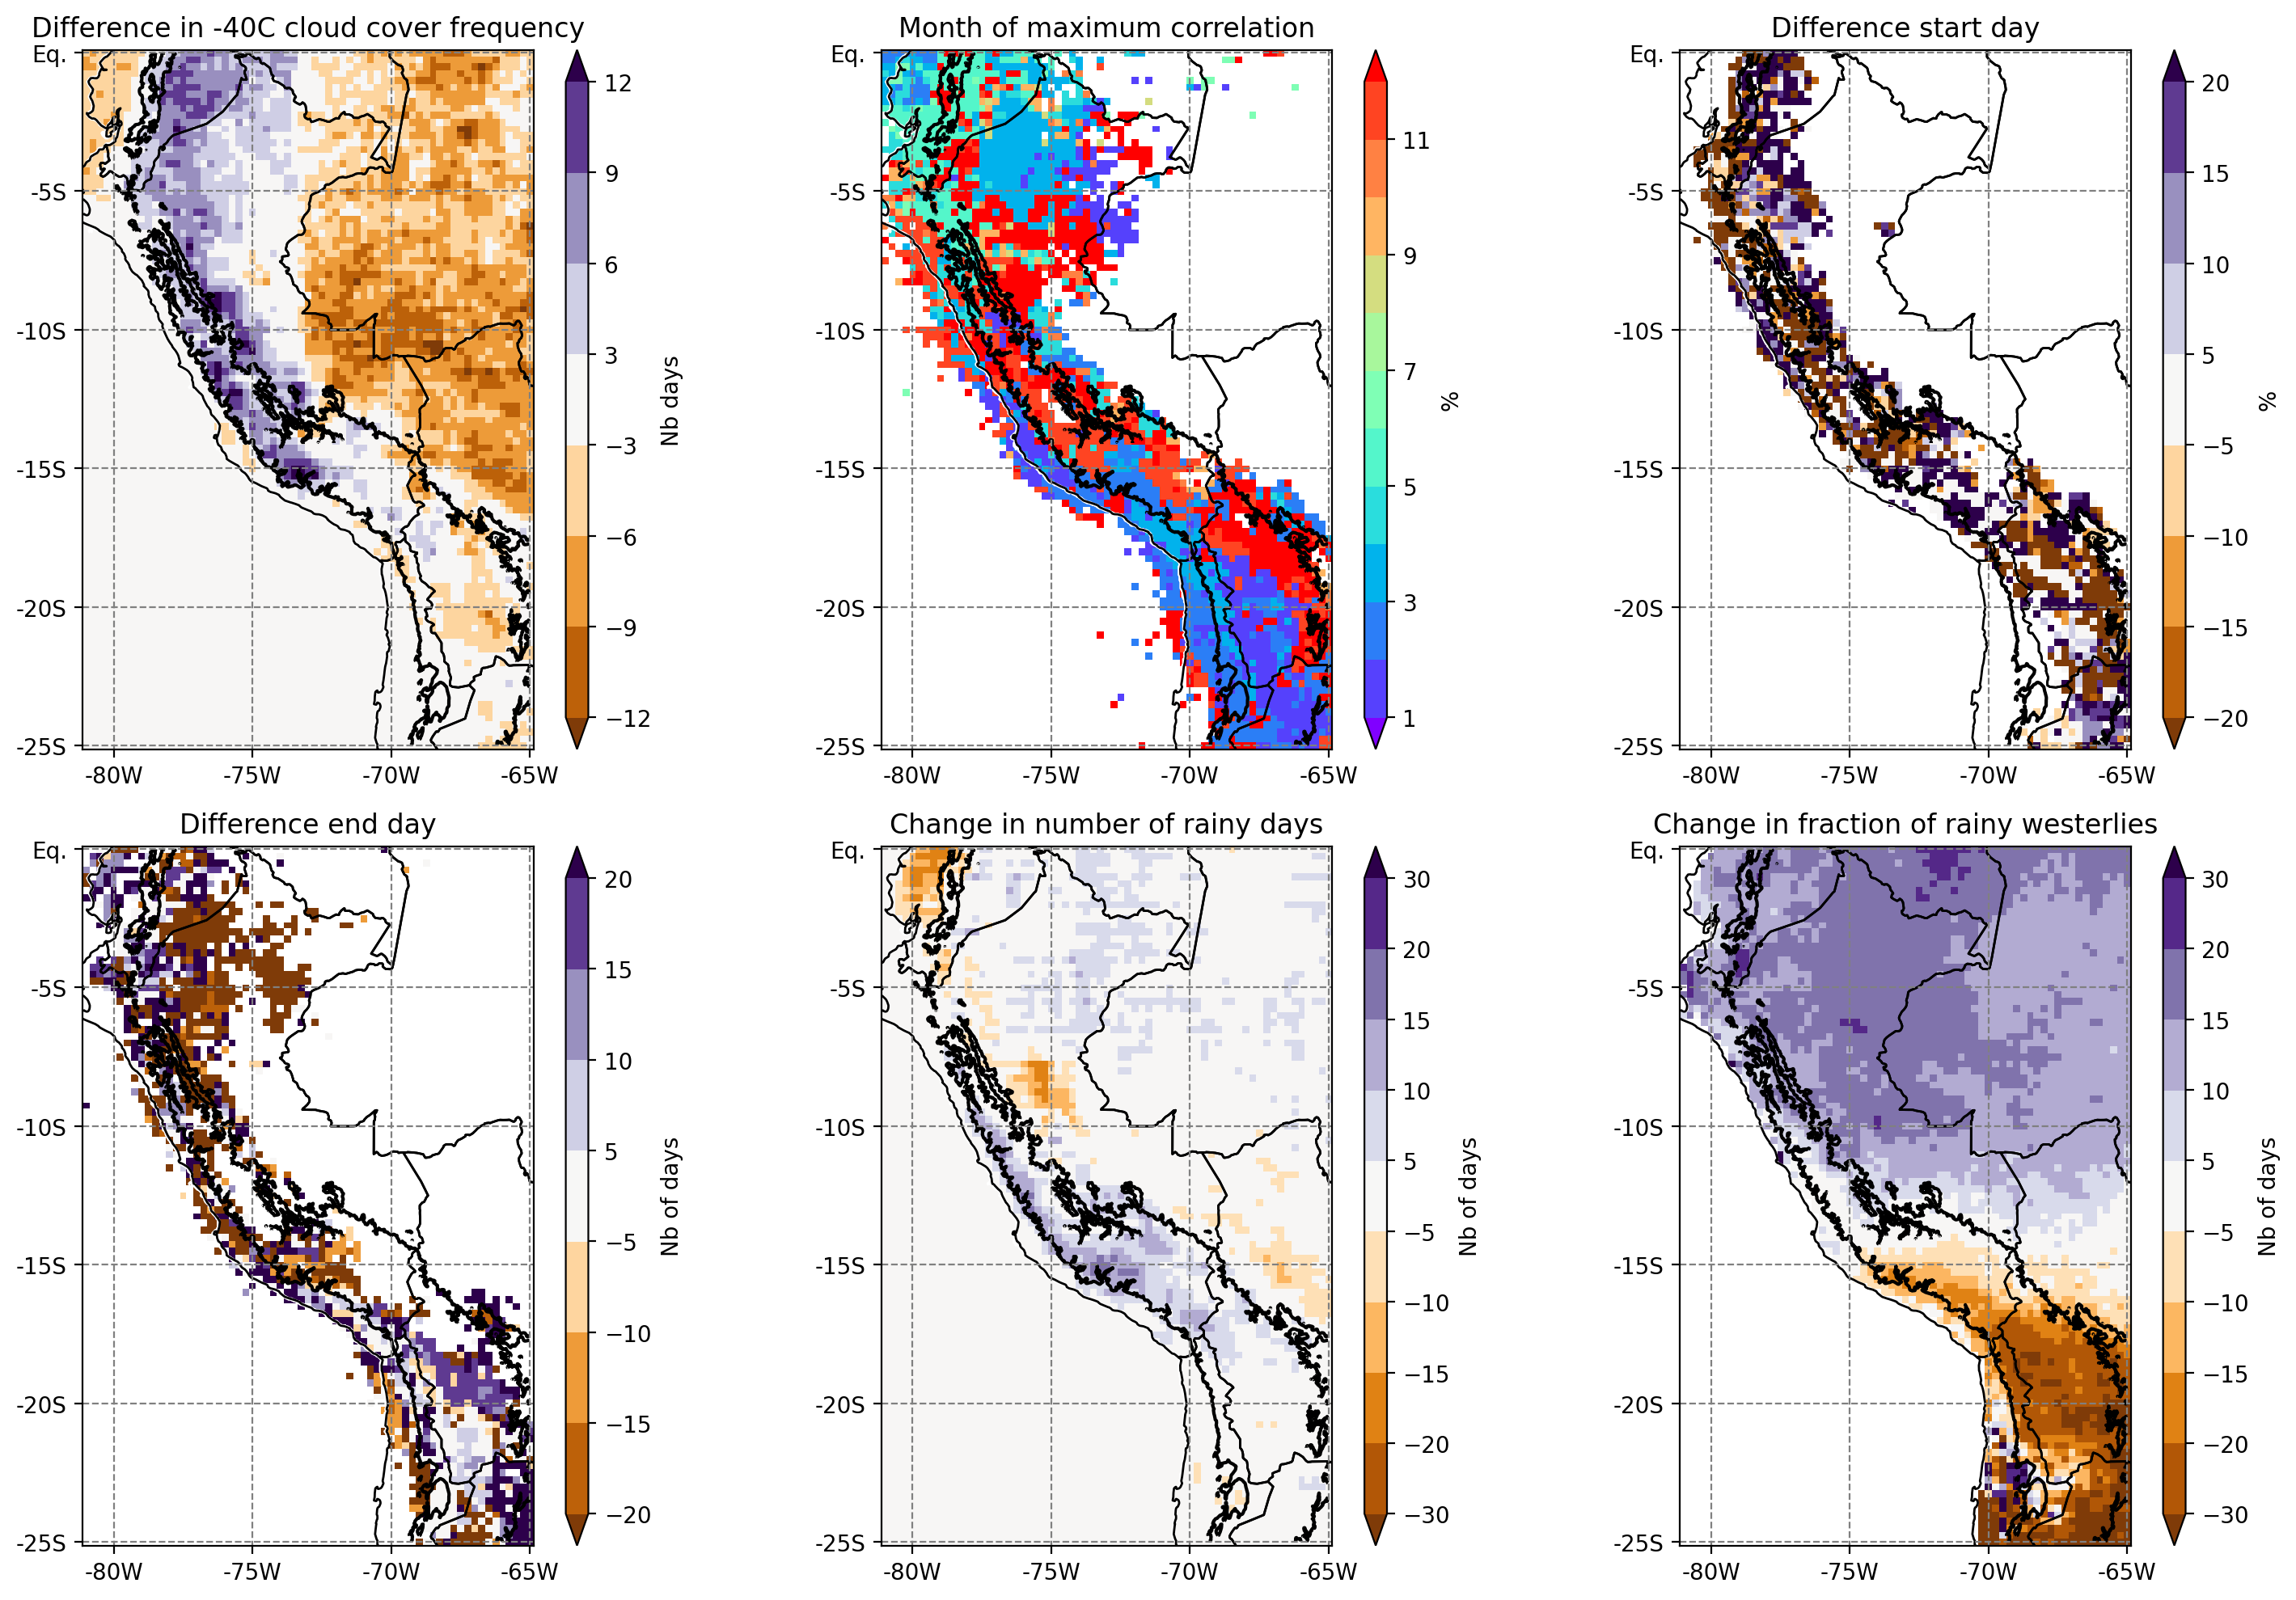

In [36]:
lakes = salem.read_shapefile(salem.get_demo_file('ne_50m_lakes.shp'),
                              cached=True)


f = plt.figure(figsize=(15,10), dpi=200)

box = [-85,-74,-10,-5]
map = corr_all.salem.get_map()
#.sel(longitude=slice(box[0],box[1]), latitude=slice(box[2], box[3]))
topo = topo#.sel(lon=slice(box[0],box[1]), lat=slice(box[2], box[3]))

# ax = f.add_subplot(231)
# #outarr_3.values[(topo_on_g<300)]=np.nan
# map.set_data(outarr_3)
# map.set_plot_params(levels=np.arange(182,335,6), cmap='jet', extend='both') #[182,213,244,274,305,335, 366]  # 182-July, 335- December
# map.set_contour(topo, interp='linear', levels=[0,3000], cmap='Greys')
# plt.plot(-77.5, -9.5, 'ro', markersize=5)
# map.visualize(cbar_title='Day of year', title='3-day correlation onset [July-November]')

# ax = f.add_subplot(232)
# endarr_5.values[(topo_on_g<300)]=np.nan # | (endarr_5<65)
# map.set_data(endarr_5)
# map.set_plot_params(levels=np.arange(60,152,6), cmap='jet_r', extend='both') # 60 March, 152 June
# map.set_contour(topo, interp='linear', levels=[0,3000], cmap='Greys')
# map.visualize(cbar_title='Day of year', title='5-day correlation retreat [March-May]')
# plt.plot(-77.5, -9.5, 'ro', markersize=5)

ax = f.add_subplot(231)
#endarr_5.values[(topo_on_g<300)]=np.nan # | (endarr_5<65)
season = (g_end-g_all)
map.set_data(season)
map.set_plot_params(levels=[-12, -9,-6, -3, 3,6,9,12], cmap='PuOr', extend='both')
map.set_contour(topo, interp='linear', levels=[0, 3000], cmap='Greys')
map.visualize(cbar_title='Nb days', title='Difference in -40C cloud cover frequency')
plt.plot(-77.5, -9.5, 'ro', markersize=5)

ax = f.add_subplot(232)
data = outmax_gt
# data.values[(corr_first_num.values<30)]=np.nan
# data.values[np.isnan(season)] = np.nan
#data[(topo_on_g<300)]=np.nan # | (endarr_5<65)
map.set_data(data)
map.set_plot_params(levels=np.arange(1,13,1), cmap='rainbow', extend='both')
map.set_contour(topo, interp='linear', levels=[0, 3000], cmap='Greys')
map.visualize(cbar_title='%', title='Month of maximum correlation')
plt.plot(-77.5, -9.5, 'ro', markersize=5)

ax = f.add_subplot(233)
data = outarr_3_end-outarr_3_first
map.set_data(data)
map.set_plot_params(levels=[-20,-15,-10, -5, 5,10,15,20], cmap='PuOr', extend='both')
map.set_contour(topo, interp='linear', levels=[0, 3000], cmap='Greys')
map.visualize(cbar_title='%', title='Difference start day')
plt.plot(-77.5, -9.5, 'ro', markersize=5)

ax = f.add_subplot(234)
data = endarr_5_end-endarr_5_first
#data.values[corr_all_num.values<60]=np.nan
#endarr_5[(topo_on_g<300)]=np.nan # | (endarr_5<65)
map.set_data(data)
map.set_plot_params(levels=[-20,-15,-10, -5, 5,10,15,20], cmap='PuOr', extend='both')
map.set_contour(topo, interp='linear', levels=[0,3000], cmap='Greys')
map.visualize(cbar_title='Nb of days', title='Difference end day')
plt.plot(-77.5, -9.5, 'ro', markersize=5)

ax = f.add_subplot(235)

data = (ch_end-ch_all)#/ch_all*100
#data = g_end-g_all
#data.values[corr_all_num.values<60]=np.nan
#endarr_5[(topo_on_g<300)]=np.nan # | (endarr_5<65)
map.set_data(data)
map.set_plot_params(levels=[-30,-20,-15,-10, -5, 5,10,15,20,30], cmap='PuOr', extend='both')
map.set_contour(topo, interp='linear', levels=[0,3000], cmap='Greys')
map.visualize(cbar_title='Nb of days', title='Change in number of rainy days')
plt.plot(-77.5, -9.5, 'ro', markersize=5)


ax = f.add_subplot(236)

data = (ch_end_frac-ch_all_frac)/ch_all_frac*100
#data = g_end-g_all
#data.values[corr_all_num.values<60]=np.nan
#endarr_5[(topo_on_g<300)]=np.nan # | (endarr_5<65)
map.set_data(data)
map.set_plot_params(levels=[-30,-20,-15,-10, -5, 5,10,15,20,30], cmap='PuOr', extend='both')
map.set_contour(topo, interp='linear', levels=[0,3000], cmap='Greys')
map.visualize(cbar_title='Nb of days', title='Change in fraction of rainy westerlies')
plt.plot(-77.5, -9.5, 'ro', markersize=5)

plt.tight_layout()

In [37]:
ispos = corr_all.isel(dayofyear=1).where((corr_all.longitude==-77.25)&(corr_all.latitude==-9.5))
pickpos = np.where(np.isfinite(ispos['r']))
y = int(pickpos[0])
x = int(pickpos[1])
date = datetime.datetime(2017, 1, 1) + pd.Timedelta(str(outmax_gt.values[y,x] - 1)+' days')
dstr = date.strftime("%d/%m")
print('Huaraz correlation maximum', outmax_gt.values[y,x], 'Date', dstr)

Huaraz correlation maximum 1.0 Date 01/01


In [38]:
topo


<xarray.DataArray 'h' (lat: 1500, lon: 960)>
array([[   0,    0,    0, ..., 1072, 1177, 1108],
       [   0,    0,    0, ..., 1024, 1151, 1117],
       [   0,    0,    0, ...,  923,  987, 1009],
       ...,
       [   0,    0,    0, ...,   86,   87,   87],
       [   0,    0,    0, ...,   85,   85,   85],
       [   0,    0,    0, ...,   83,   84,   84]], dtype=int16)
Coordinates:
  * lon      (lon) float32 -80.99167 -80.975 -80.958336 ... -65.025 -65.00834
  * lat      (lat) float32 -24.991669 -24.974998 ... -0.025001526 -0.008338928
Attributes:
    long_name:  Altitude
    units:      m